# GoogleNet

![대체 텍스트](https://cdn-images-1.medium.com/max/2560/1*ZFPOSAted10TPd3hBQU8iQ.png)

In [2]:
!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

rm: cannot remove 'images': No such file or directory
--2020-08-27 07:34:56--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.194.166, 151.101.2.166, 151.101.66.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.194.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.009s  

2020-08-27 07:34:56 (3.52 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2020-08-27 07:34:56--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... connected.
HTTP request sent, awaiting 

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [4]:
batch_size= 1
learning_rate = 0.0002
num_epoch = 100

In [5]:
img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))


train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [6]:
def conv_1(in_dim,out_dim): # 1*1 convolution
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,1,1),
      nn.ReLU()
  )
  return model
def conv_1_3(in_dim,mid_dim,out_dim): # 1*1 -> 3*3 convolution
  model = nn.Sequential(
      nn.Conv2d(in_dim,mid_dim,1,1),
      nn.ReLU(),
      nn.Conv2d(mid_dim,out_dim,3,1,1),
      nn.ReLU()
  )
  return model
def conv_1_5(in_dim,mid_dim,out_dim): # 1*1 -> 5*5 convolution
  model = nn.Sequential(
      nn.Conv2d(in_dim,mid_dim,1,1),
      nn.ReLU(),
      nn.Conv2d(mid_dim,out_dim,5,1,2),
      nn.ReLU()
  )
  return model

def max_3_1(in_dim,out_dim): # 3*3 maxpooling -> 1*1 convolution
  model = nn.Sequential(
      nn.MaxPool2d(3,1,1),
      nn.Conv2d(in_dim,out_dim,1,1),
      nn.ReLU()
  )
  return model

In [7]:
# inception module
class inception_module(nn.Module):
  def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool):
    super(inception_module,self).__init__()
    self.conv_1 = conv_1(in_dim,out_dim_1)
    self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
    self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
    self.max_3_1 = max_3_1(in_dim,pool)

  def forward(self,x):
    out_1 = self.conv_1(x)
    out_2 = self.conv_1_3(x)
    out_3 = self.conv_1_5(x)
    out_4 = self.max_3_1(x)
    output = torch.cat([out_1,out_2,out_3,out_4],1)
    return output

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*CWJGqfLiVjHAIan82nPbjg.png)

In [12]:
class GoogleNet(nn.Module):
  def __init__(self,base_dim,num_classes = 2):
    super(GoogleNet,self).__init__() # 자기 상속
    self.num_classes = num_classes
    self.layer_1 = nn.Sequential(
        nn.Conv2d(3,base_dim,7,2,3),
        nn.MaxPool2d(3,2,1),
        nn.Conv2d(base_dim,base_dim*3,3,1,1),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_2 = nn.Sequential(
        inception_module(base_dim*3,64,96,128,16,32,32), # 표의 inception(3a)
        inception_module(base_dim*4,128,128,192,32,96,64), # inception(3b)
        nn.MaxPool2d(3,2,1)
    )
    self.layer_3 = nn.Sequential(
        inception_module(480,192,96,208,16,48,64), # inception(4a)
        inception_module(512,160,112,224,24,64,64), # inception(4b)
        inception_module(512,128,128,256,24,64,64), # inception(4c)
        inception_module(512,112,144,288,32,64,64), # inception(4d)
        inception_module(528,256,160,320,32,128,128), # inception(4e)
        nn.MaxPool2d(3,2,1)
    )
    self.layer_4 = nn.Sequential(
        inception_module(832,256,160,320,32,128,128), # inception(5a)
        inception_module(832,384,192,384,48,128,128), # inception(5b)
        nn.AvgPool2d(7,1) # average pooling
    )
    self.layer_5 = nn.Dropout2d(0.4)
    self.fc_layer = nn.Linear(1024,self.num_classes)

  def forward(self,x):
    out = self.layer_1(x)
    out = self.layer_2(out)
    out = self.layer_3(out)
    out = self.layer_4(out)
    out = self.layer_5(out)
    out = out.view(batch_size,-1)
    out = self.fc_layer(out)
    return out

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = GoogleNet(base_dim = 64)
for i in model.named_children():
  print(i)

model = GoogleNet(base_dim = 64).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

('layer_1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
))
('layer_2', Sequential(
  (0): inception_module(
    (conv_1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (conv_1_3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_1_5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (max_3_1): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1,

In [16]:
loss_arr = []
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x = image.to(device)
    y_ = label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output,y_)
    loss.backward()
    optimizer.step()

  if i%10 == 0:
    print(loss)
    loss_arr.append(loss)


tensor(0.4011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3925, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0733, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4303, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3625, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3868, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4369, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.3716, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5711, device='cuda:0', grad_fn=<NllLossBackward>)


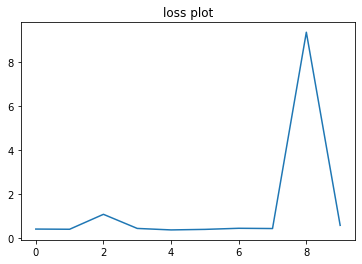

In [18]:
import matplotlib.pyplot as plt
plt.title('loss plot')
plt.plot(loss_arr)
plt.show()